# Pokemon classifier
version 0.2 by BennyFace

model: pokemon_v02_convnext_large_in22k.pkl
dataset: https://huggingface.co/datasets/keremberke/pokemon-classification

In [1]:
from fastai.vision.all import *
import gradio as gr
import os
import timm

In [2]:
home_path = os.getcwd()
home_path

'/home/bennyface'

In [3]:
home = Path(home_path)

In [4]:
pokemon = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [5]:
accum = 2 # increase to lower vram
dls = pokemon.dataloaders(source = "/mnt/d/datasets/pokemon/", bs=64//accum)

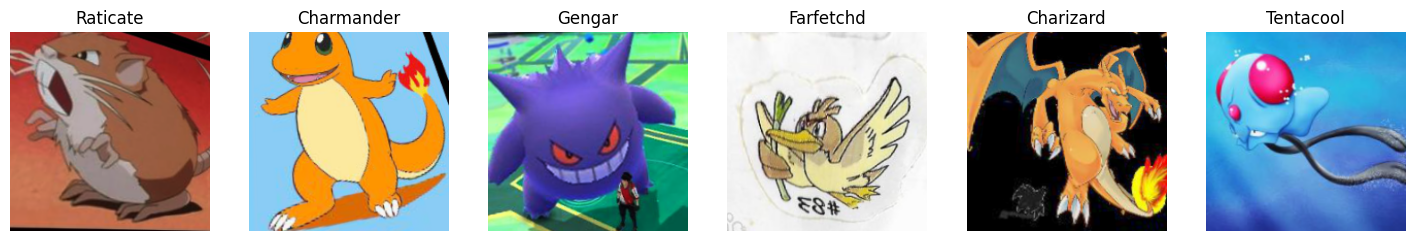

In [6]:
dls.train.show_batch(max_n=6, nrows=1)

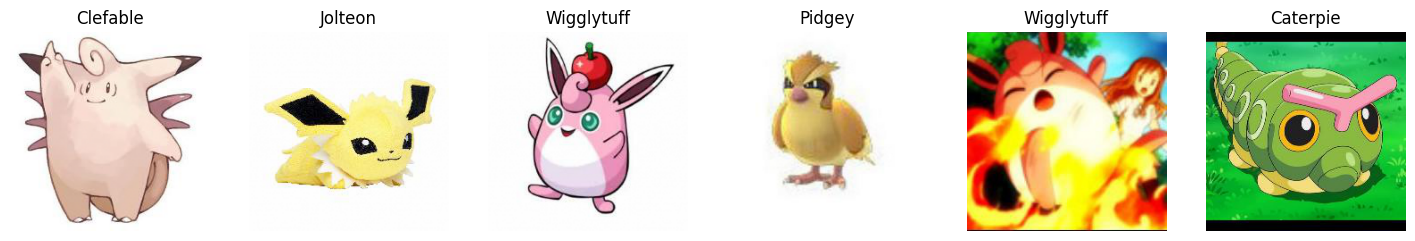

In [7]:
dls.valid.show_batch(max_n=6, nrows=1)

In [8]:

cbs = GradientAccumulation(64) if accum else []
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate, cbs=cbs).to_fp16()

SuggestedLRs(valley=0.004365158267319202, slide=2.0892961401841603e-05)

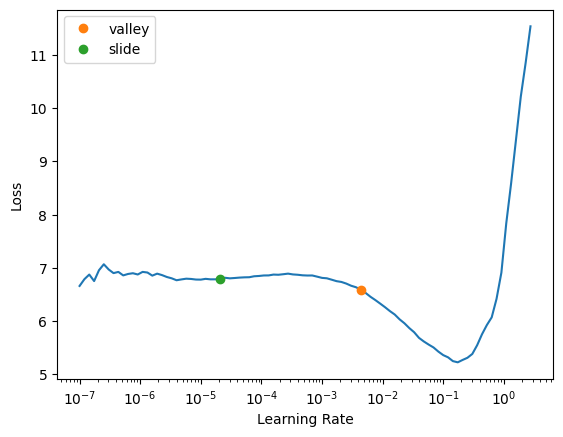

In [9]:
learn.lr_find(suggest_funcs=(valley, slide))

In [10]:
#train the model
learn.fine_tune(12, 0.003)

epoch,train_loss,valid_loss,error_rate,time
0,2.462896,0.737206,0.177396,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.615077,0.387770,0.078684,01:44
1,0.297572,0.265633,0.059371,01:43
2,0.209376,0.236846,0.066524,01:43
3,0.134825,0.218055,0.052933,01:43
4,0.092879,0.201040,0.046495,01:43
5,0.065404,0.193440,0.040057,01:43
6,0.047553,0.181950,0.040057,01:43
7,0.048394,0.166583,0.037196,01:44
8,0.035490,0.155624,0.037196,01:44
9,0.029675,0.147344,0.031474,01:43


In [11]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0308)

In [12]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0265)

In [13]:
# get the index with the greater probability
preds = probs.argmax(dim=1)

In [14]:
dls.vocab[preds]

(#1398) ['Clefable','Jolteon','Wigglytuff','Pidgey','Goldeen','Caterpie','Persian','Golbat','Tentacruel','Golbat'...]

In [15]:
learn.export('/home/bennyface/pokemon_v02_convnext_large_in22k.pkl')

In [16]:
learning_interpreter = ClassificationInterpretation.from_learner(learn)

In [17]:
# too many catergories
# learning_interpreter.plot_confusion_matrix()

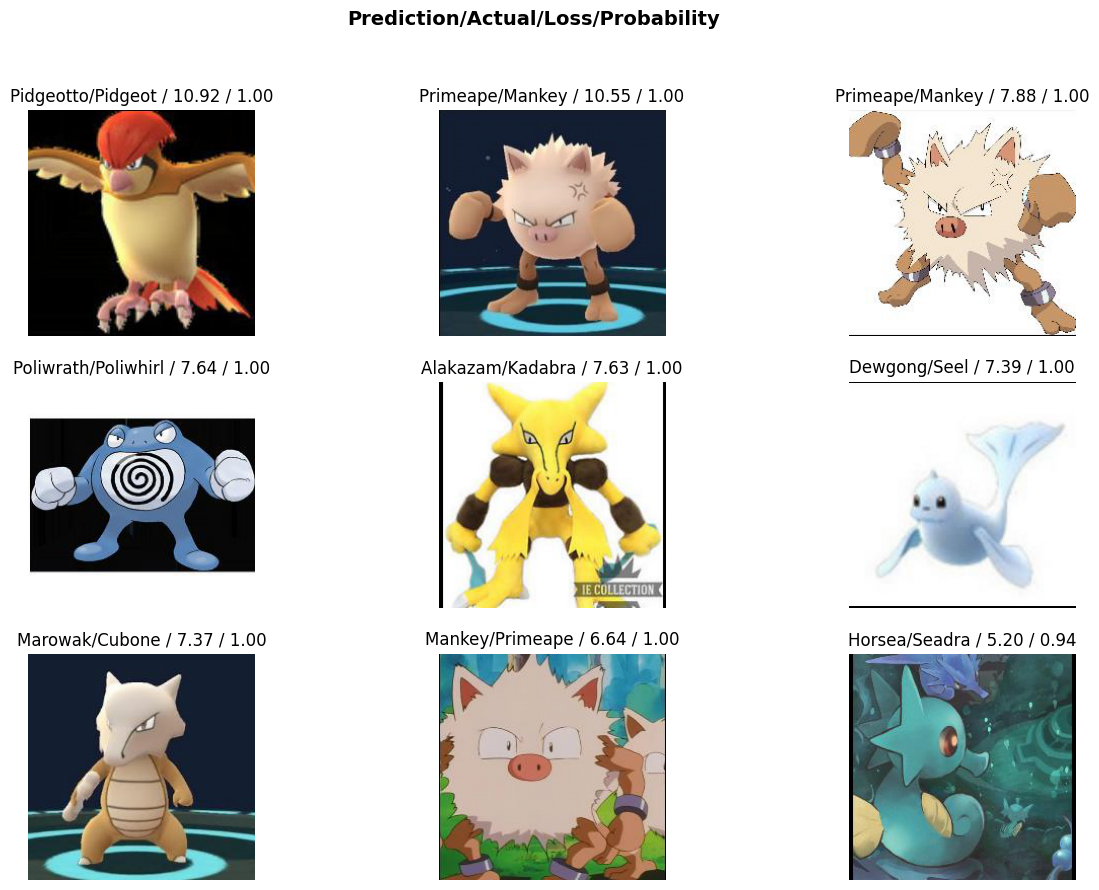

In [18]:
learning_interpreter.plot_top_losses(9, figsize=(15,10))

## Gradio App

In [19]:
#imports, not required if  run above

from fastai.vision.all import *
import gradio as gr
import os
import timm

In [20]:
learn = load_learner('/home/bennyface/pokemon_v02_convnext_large_in22k.pkl')

In [21]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [22]:
gr.Interface(fn=predict, inputs=gr.Image(shape=(512, 512)), outputs=gr.Label(num_top_classes=3)).launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://a2f08fad-c02e-4d07.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [ ]:
# ??ImageDataLoaders.from_folder

In [ ]:
timm.list_models(pretrained=True)